In [1]:
import PIL as pil
from PIL import Image
import math

# v1: First draft + QC
Explanations throughout, in markdown cells and codenotes. This is a walkthrough of a two-part function thought up by Nils Harder. Here I am putting his idea into Python, leaving the syntax as readable and step-by-step as possible, so it can be easily adapted and adjusted as this idea evolves. Subsequent drafts will not have as detailed descriptions at each step. Oversaturation is not accounted for in this version.

## Part I
#### Input: path to image1, desired number of rows and columns for 'tiles' of image 1
#### Output: list of [r, g, b] values corresponding to the *center pixel* in each tile

In [2]:
def img1_tileRGBs(path, num_cols, num_rows):

    pic1 = pil.Image.open(path).convert('RGB')
    width1, height1 = pic1.size
    
    px_per_col = math.ceil(width1/num_cols)
    px_per_row = math.ceil(height1/num_rows)
    
    ###This block could be consolidated, but leaving each step independent for future tinkering
    ###ie changing to average rgb per tile instead of center-value, etc.
    #find pixel-ranges of each col and row
    chunk_it_up_cols = [(x,x+px_per_col) for x in range(0, width1, px_per_col)]
    chunk_it_up_rows = [(y,y+px_per_row) for y in range(0, height1, px_per_row)]
    #adjust very last pixel_num since rows/cols probably didn't divide evenly
    chunk_it_up_cols[-1] = (chunk_it_up_cols[-1][0], width1)
    chunk_it_up_rows[-1] = (chunk_it_up_rows[-1][0], height1)
    #find center pixel in each col and row
    col_centers = [(i[0]+i[1])//2 for i in chunk_it_up_cols]
    row_centers = [(i[0]+i[1])//2 for i in chunk_it_up_rows]
    #knit into tuple, coordinate of px at the center of each tile
    center_px_coords = [(x,y) for x in col_centers for y in row_centers]
    #the order of center_px_coords is (col_0,row_0), (col_0,row_1), (col_0, row_2) ... on to col_1 once reach num_rows
    
    #rgb values for each center pixel
    return [list(pic1.getpixel(i)) for i in center_px_coords]

demo_pic1 [image source](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/) (and some PIL basics)  

demo_pic2 [image source](https://edit.co.uk/blog/8-alternatives-generic-stock-photography-help-improve-bounce-rate/)

In [3]:
demo_pic1 = './opera.jpeg'
num_rows = 10 #random
num_cols = 15

p1_centerpx_rgbs = img1_tileRGBs(demo_pic1, num_cols, num_rows)

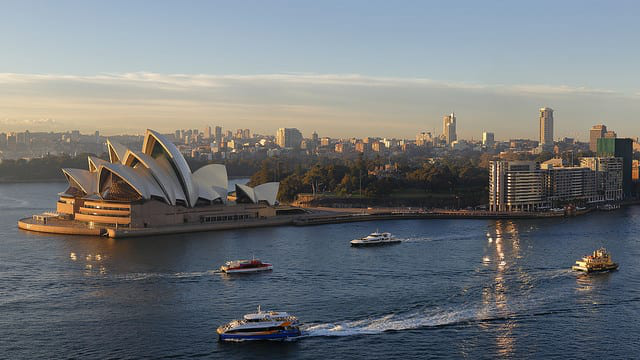

In [4]:
#for reference:
img1_looks_like_this = pil.Image.open('./opera.jpeg')
img1_looks_like_this

## Part II
#### Input: path to image 2
#### Output: exported image for each item in Part_I_output_list
* The colors of each export has been shifted so the _average overal R,G,B_ of the exported img matches the R,G,B of the Part_I_list_entry  
  
Code for total_avg 'adapted' (read: swiped) from [Sp3000's answer here](https://codegolf.stackexchange.com/questions/53621/force-an-average-on-an-image)

In [5]:
def total_avg(img_path):
    img = pil.Image.open(img_path).convert('RGB')
    width, height = img.size
    
    total_rgb = [0, 0, 0]
    
    for x in range(width):
        for y in range(height):
            for i in range(3): #rgb channels
                total_rgb[i] += img.getpixel((x,y))[i]
                
    return [int(i / (height*width)) for i in total_rgb]

In [6]:
demo_pic2 = './stock.png'

Ri, Gi, Bi = total_avg(demo_pic2)
print(Ri, Gi, Bi)

148 142 143


In [7]:
def all_the_exports(img_path, out_path, num_cols, num_rows, reference_rgbs):
    col = 1 #counters for export filenames
    row = 1
    
    for i in reference_rgbs:
        Rf, Gf, Bf = i
        Rmod, Gmod, Bmod = Rf-Ri, Gf-Gi, Bf-Bi
        
        #when you edit values in the pixel_map, it is changed the source image
        #thus must reload source image each iteration to reset the modified pixels
        pic2 = pil.Image.open(img_path).convert('RGB')
        p2_pixelmap = pic2.load()
        width2, height2 = pic2.size
        
        for x in range(width2):
            for y in range(height2):
                p2_pixelmap[x,y] = (p2_pixelmap[x,y][0]+Rmod, p2_pixelmap[x,y][1]+Gmod, p2_pixelmap[x,y][2]+Bmod)
                #this syntax defacto restricted to 0-255. No risk of negatives or >255
                
        pic2.save(f'{out_path}/col{col}row{row}.png')
        row += 1
        if (row-1) % num_rows == 0:
            row = 1
            col += 1

In [8]:
out_path = './scratch/prac_images/test_export1'

all_the_exports(demo_pic2, out_path, num_cols, num_rows, p1_centerpx_rgbs)

## Check output

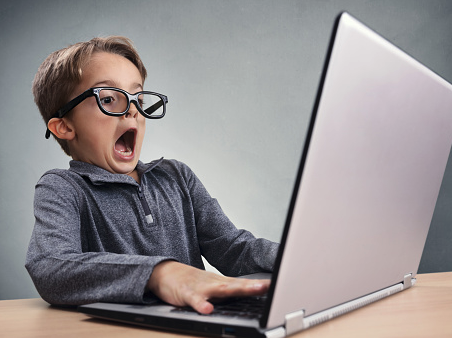

In [9]:
#original img2
pic2 = pil.Image.open('./stock.png').convert('RGB')
pic2

In [10]:
##to open all examples in desktop viewer, run the following:
# import os
# for i in os.listdir('./example_outputs/'):
#     mod_img = pil.Image.open(f'./example_outputs/{i}')
#     mod_img.show()

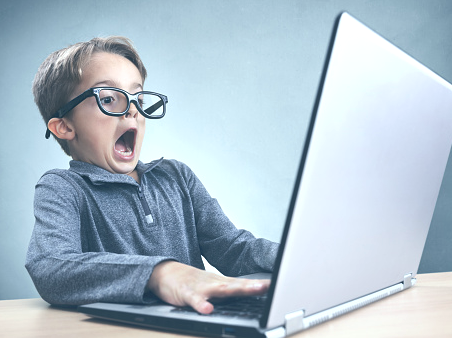

In [11]:
example_1 = pil.Image.open('./example_outputs/col1row1.png')
example_1

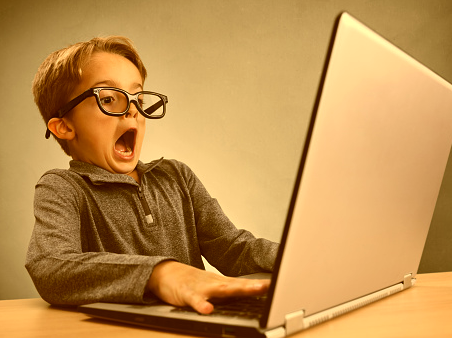

In [12]:
example_2 = pil.Image.open('./example_outputs/col2row6.png')
example_2

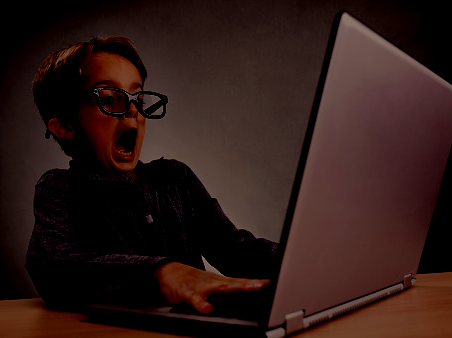

In [13]:
example_3 = pil.Image.open('./example_outputs/col3row7.png')
example_3

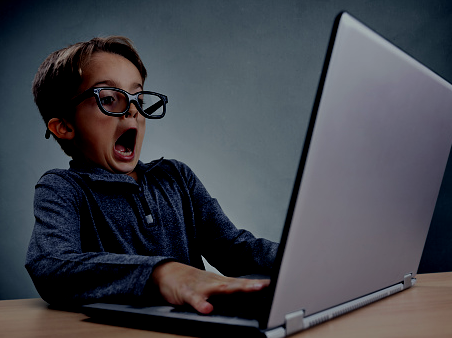

In [14]:
example_4 = pil.Image.open('./example_outputs/col15row6.png')
example_4

## _Look harder_
Ok visually, we've confirmed we have generated images with altered color spectrums. That was the overall goal, but are these the right alterations? The idea is that each output-image2 could be tiled in its corresponding position to render an approximation of the original image1 (with varying resolution).  

I don't want to orient all 150 of the export images into a proper collage to check (plus this example run of a 15x10 grid is not high enough resolution to properly represent the Sydney Opera House). But, let's spot check the _technical_ output of some images, instead of just the visual pass we did above.  

I'm going to alter some of the above functions to give us specific pixel-coordinates and rgbs to cross-reference.

In [15]:
def img1_qc(path, num_cols, num_rows): 
    #same as img1_tileRGBs but different return

    pic1 = pil.Image.open(path).convert('RGB')
    width1, height1 = pic1.size
    
    px_per_col = math.ceil(width1/num_cols)
    px_per_row = math.ceil(height1/num_rows)
    
    chunk_it_up_cols = [(x,x+px_per_col) for x in range(0, width1, px_per_col)]
    chunk_it_up_rows = [(y,y+px_per_row) for y in range(0, height1, px_per_row)]
    chunk_it_up_cols[-1] = (chunk_it_up_cols[-1][0], width1)
    chunk_it_up_rows[-1] = (chunk_it_up_rows[-1][0], height1)

    col_centers = [(i[0]+i[1])//2 for i in chunk_it_up_cols]
    row_centers = [(i[0]+i[1])//2 for i in chunk_it_up_rows]
    center_px_coords = [(x,y) for x in col_centers for y in row_centers]
    #the order of center_px_coords is (col_0,row_0), (col_0,row_1), (col_0, row_2) ... on to col_1 once reach num_rows
    
    #rgb values for each center pixel
    return zip(center_px_coords, [list(pic1.getpixel(i)) for i in center_px_coords])

In [16]:
img1_qc_specs = img1_qc(demo_pic1, num_cols, num_rows)

In [17]:
img1_qc_specs = list(img1_qc_specs)
img1_qc_specs[0:5]

[((21, 18), [174, 192, 206]),
 ((21, 54), [193, 204, 206]),
 ((21, 90), [205, 199, 183]),
 ((21, 126), [194, 177, 147]),
 ((21, 162), [86, 87, 81])]

#### What are we looking at?
The above ziplist (probably a word) shows that pixel location (21,18) is the center of the first tile of image1. This pixel has R=174, G=192, B=206.
* Let's call this rgb_uno

We know from our part II output that the overall average of image2 is R=148, G=142, B=143
* rgb_dos

Thus, the exported_image2 at col1row1 should have modified RGBs that _average_ RGB-belpha

In [18]:
rgb_uno = img1_qc_specs[0][1]
rgb_uno #RGB of img1, pixel at center of tile1

[174, 192, 206]

In [19]:
rgb_dos = [Ri, Gi, Bi] #overall avg RGB of img2
rgb_dos

[148, 142, 143]

In [20]:
#modify all RGB values in image2 so the overall average matches rgb_uno

Rf, Gf, Bf = rgb_uno
Rmod, Gmod, Bmod = Rf-Ri, Gf-Gi, Bf-Bi
        
pic2 = pil.Image.open(demo_pic2).convert('RGB')
p2_pixelmap = pic2.load()
width2, height2 = pic2.size
        
for x in range(width2):
    for y in range(height2):
        p2_pixelmap[x,y] = (p2_pixelmap[x,y][0]+Rmod, p2_pixelmap[x,y][1]+Gmod, p2_pixelmap[x,y][2]+Bmod)
pic2.save(f'{out_path}/col1row1_qc.png')

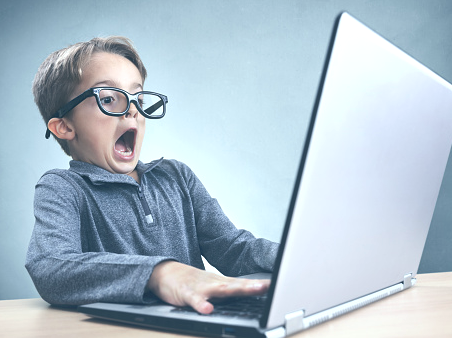

In [21]:
pic2 #appears identical to example_1 (manual replication)

In [22]:
#pic2==example_1  --> returns false, convert to array and check each element
import numpy as np
pic2_array = np.asarray(pic2)
ex1_array = np.asarray(example_1)
print('qc and export arrays identical?: ',(pic2_array == ex1_array).all())

qc and export arrays identical?:  True


In [23]:
print('output RGB actual avg = ', total_avg(f'{out_path}/col1row1_qc.png'))
print('should equal rgb_uno: ', rgb_uno)

output RGB actual avg =  [173, 191, 204]
should equal rgb_uno:  [174, 192, 206]


Ok...we are close. Rounding can account for a +/- 2 here or there, but this does raise concern. Let's QC another example, one from the back of the bus to make sure things aren't diverging later.

In [24]:
#example_4 = column 15, row 6 center pixel @ (621, 198)
print(f'center pixel {img1_qc_specs[-5][0]} has RGB = {img1_qc_specs[-5][1]}')
print('col15row6 output RGB actual avg = ', total_avg('./example_outputs/col15row6.png'))

center pixel (621, 198) has RGB = [59, 62, 71]
col15row6 output RGB actual avg =  [66, 68, 76]


### Back to the drawing board
This is not as close as I want. Potential sources of divergence are areas where floats are rounded (since can't have partial pixels), and 'oversaturation'.  
The 'oversaturation' conflict arises because the modification across images is just simple addition or subtraction for pixel and channel.  ie To reduce the overall average of a channel by 15, we are subtracting 15 from every value in that channel. However, for any values <= 15, this would be only a partial subtraction since no value can be below 0, so the overall average might clock is as higher than the goal. Same at the other end for values that would exceed 255.  
This issue was brought up preemptively in project description by Nils Harder, but not addressed in this first draft. Time to find a fix.